# State-by-state primary voting trends
- dirichlet transmission model
- but no house-effects model
- and not constrained back to any national model

__NOTE:__
* Please run the *_data_capture.ipynb* notebook before running this notebook.

## Set-up

In [1]:
# system imports
from pathlib import Path
from typing import Any, NotRequired, TypedDict
from functools import cache

# analytic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# PyMC imports
import arviz as az  # type: ignore[import-untyped]
import pymc as pm  # type: ignore[import-untyped]

In [2]:
# local import
import bayes_tools
import plotting
from common import (
    MIDDLE_DATE,
    VOTING_INTENTION,
    ensure,
)
from data_capture import retrieve

In [3]:
# plotting related
SHOW = False  # show charts in the notebook

# model diagram
MODEL_DIR = "../model-images/"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

In [4]:
## Plotting initialisation
def set_up_plotting() -> None:
    """Set up plotting."""

    p = plotting.get_chart_dir()
    plotting.set_chart_dir(p + '/bayesian-state-primary-aggregation/')
    plotting.clear_chart_dir()


set_up_plotting()

### Check operating environment

In [5]:
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.13.2
IPython version      : 9.0.2

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

arviz     : 0.21.0
pymc      : 5.21.1
matplotlib: 3.10.1
pandas    : 2.2.3
IPython   : 9.0.2
numpy     : 2.2.4

Watermark: 2.5.0



## Get data

In [6]:
ORDERED_PARTIES = ["Coalition", "Labor", "Greens", "Others"]
ORDERED_STATES = ["NSW", "VIC", "QLD", "WA", "SA", "TAS", "NT", "ACT"]

### State poll results

In [7]:
def get_poll_data() -> dict[str, pd.DataFrame]:
    """Retrieve raw data after running the data capture notebook."""

    retrieved = retrieve()
    ensure(retrieved, "You must run the data capture notebook every day.")
    return retrieved

In [8]:
def extract_state_polls(
    raw: dict[str, pd.DataFrame] | None = None,
) -> dict[str, pd.DataFrame]:
    """Retrieve the state polls as simplex from the raw data.
    While there is no ACT data, we are assuming it is the same as NSW."""

    if raw is None:
        raw = get_poll_data()

    cooked_data = {}
    for state in ORDERED_STATES:
        if state not in raw:
            print(f"Missing {state} data")
            continue
        data = raw[state].copy()  # don't modify the raw data
        data = plotting.amalgamate_other(data)
        data.index = pd.PeriodIndex(data[MIDDLE_DATE], freq="M")

        data = data.sort_index(ascending=True)
        renamer = {
            "Primary vote LNP": "Coalition",
            "Primary vote L/NP": "Coalition",
            "Primary vote CLP": "Coalition",
            "Primary vote ALP": "Labor",
            "Primary vote GRN": "Greens",
            "Primary vote Other": "Others",
        }
        data = data.rename(columns=renamer)
        keep = list(set(renamer.values()))
        data = data[keep].dropna(how="all")
        data = data[ORDERED_PARTIES]  # correct order

        row_sum = data.sum(axis=1, skipna=False)
        bad = (row_sum < 99.99) | (row_sum > 100.01) | row_sum.isna()
        if bad.any():
            print(f"Bad data for {state}")
            print(data[bad])
            data = data[~bad]

        # sanity checks
        assert data.index.is_monotonic_increasing
        cooked_data[state] = data / 100.0  # onto the simplex

    return cooked_data


STATE_POLLS = extract_state_polls()
_ = "------------------"
print(f"\n{_}\nState poll counts:")
for key, value in STATE_POLLS.items():
    print(f"{key} {len(value)}")
print(_)

Bad data for WA
           Coalition      Labor  Greens  Others
Mean Date                                      
2024-10    49.275362  50.724638     NaN     NaN
Missing ACT data

------------------
State poll counts:
NSW 46
VIC 47
QLD 47
WA 16
SA 13
TAS 3
NT 1
------------------


### Previous election - state and national starting points

In [9]:
def previous_election_primary() -> tuple[pd.DataFrame, pd.Series]:
    """Retrieve the primary vote shares from the previous election.
    returns a table of state values and a series of national values
    on the simplex.
    Note: NSW includes the ACT"""

    csv = "../historic-data/HouseFirstPrefsByStateByPartyDownload-27966.csv"
    data = pd.read_csv(csv, sep=",", header=0, skiprows=1)
    data_total = data[["StateAb", "PartyAb", "TotalVotes"]]
    pdata = data_total.pivot(index="StateAb", columns="PartyAb", values="TotalVotes")
    labor = pdata["ALP"]
    greens = pdata["GRN"]
    coalition_p = [
        "LP",
        "NP",
        "LNP",
        "CLP",
    ]
    coalition = pdata[coalition_p].sum(axis=1)
    other_p = [
        x for x in data.PartyAb.unique() if x not in coalition_p + ["ALP", "GRN"]
    ]
    others = pdata[other_p].sum(axis=1)
    summary = pd.DataFrame(
        {"Coalition": coalition, "Labor": labor, "Greens": greens, "Others": others}
    )
    national = summary.sum()
    national = national / national.sum()
    national = national[ORDERED_PARTIES]
    summary = summary.div(summary.sum(axis=1), axis=0)
    summary = summary[ORDERED_PARTIES]  # reorder
    summary = summary.T[ORDERED_STATES]  # reorder
    return summary, national


previous_state, previous_national = previous_election_primary()
print(previous_national)
display(previous_state.round(2))

Coalition    0.357004
Labor        0.325808
Greens       0.122517
Others       0.194671
dtype: float64


StateAb,NSW,VIC,QLD,WA,SA,TAS,NT,ACT
Coalition,0.37,0.33,0.40,0.35,0.36,0.33,0.29,0.27
Labor,0.33,0.33,0.27,0.37,0.34,0.27,0.38,0.45
Greens,0.10,0.14,0.13,0.12,0.13,0.12,0.13,0.19
Others,0.20,0.20,0.20,0.16,0.17,0.28,0.19,0.10


## Data preparation

### National Data

In [10]:
def get_timeline() -> tuple[pd.Period, pd.Period]:
    """Get the start and end of the timeline for the national data."""

    national = retrieve()
    national_dates = pd.PeriodIndex(
        national[VOTING_INTENTION][MIDDLE_DATE].dropna(), freq="M"
    )

    # - time frames
    first_month = national_dates.min()
    last_month = national_dates.max()
    return first_month, last_month


FIRST_MONTH, LAST_MONTH = get_timeline()
N_MONTHS = (LAST_MONTH - FIRST_MONTH).n + 1
assert N_MONTHS > 1

# - parties
N_PARTIES = len(ORDERED_PARTIES)

# - transmission factors
START_C = 10_000
TRANSITION_C = 2_000
POLLING_C = 1_000


### State data

In [11]:
def build_states_data() -> dict[str, dict[str, Any]]:
    """Build the state data for the model."""

    states_data: dict[str, dict[str, Any]] = {}
    for state in ORDERED_STATES:
        if state not in STATE_POLLS:
            # No data for the ACT?
            continue
        state_data: dict[str, Any] = {}
        y = STATE_POLLS[state]
        assert y.index.min() >= FIRST_MONTH
        assert y.index.max() <= LAST_MONTH
        state_data["y"] = y.to_numpy()
        state_data["n_polls"] = len(STATE_POLLS[state])
        state_data["start"] = previous_state[state].to_numpy() * START_C

        # -- expected state monthly based on national trends
        state_data["poll_month"] = [(x - FIRST_MONTH).n for x in y.index]
        states_data[state] = state_data

    return states_data


STATES_DATA = build_states_data()

## Build a model to estimate state based voting intention

### Sampler settings

In [12]:
class SampleSettings(TypedDict):
    """The settings for the Bayesian model."""

    draws: int
    tune: int
    cores: int
    chains: int
    nuts_sampler: str
    nuts: NotRequired[dict[str, Any]]  # Requires Python 3.11
    plot_trace: NotRequired[bool]


def sampler_settings() -> SampleSettings:
    """Return the settings for sampling."""

    core_chains = 5
    settings: SampleSettings = {
        "draws": 2_000,  # number of samples per core
        "tune": 2_000,  # number of tuning steps per core
        "cores": core_chains,
        "chains": core_chains,
        "nuts_sampler": "numpyro",
        "plot_trace": False,
    }

    return settings

### Model build

In [13]:
def build_model(
    for_state: str,
) -> pm.Model:
    """Builds a PyMC model for a monthly dirichlet progression."""

    # -- state specifiv data
    assert for_state in STATES_DATA
    params = STATES_DATA[for_state]
    start = params["start"]
    print(for_state)

    # -- model
    n_polls = params["n_polls"]
    coords = {
        "parties": range(N_PARTIES),
        "months": range(N_MONTHS),
        "polls": range(n_polls),
    }

    with (model := pm.Model(coords=coords)):
        # Initial voting intention (Dirichlet prior)
        # Note: The election start date is not the first month!
        election = pm.Dirichlet("election", a=start, dims=("parties",))

        # subsequent months voting intention
        vi_list: list[pm.Dirichlet] = []
        for i in range(0, N_MONTHS):
            prev = election if i == 0 else vi_list[i - 1]
            vi_list.append(
                pm.Dirichlet(f"vi_{i}", a=(prev * TRANSITION_C), dims=("parties",))
            )

        # stack the voting intentions
        vi_stack = pm.Deterministic(
            "vi_stack",
            pm.math.stack(vi_list, axis=0),
            dims=("months", "parties"),
        )

        # Likelihood model: observed polls follow a Dirichlet distribution
        m = np.array(params["poll_month"]).astype(int)
        y = params["y"]
        _observed = pm.Dirichlet(
            "observed",
            # a=vi_adjusted[m, :] * POLLING_C,
            a=vi_stack[m, :] * POLLING_C,
            observed=y,
            dims=("polls", "parties"),
        )

    return model

### Run the model for each State

In [14]:
def run_the_model(make_map: bool = False) -> dict[str, tuple]:
    """Run the model for each state and return the results."""

    results: dict[str, tuple] = {}
    for state in ORDERED_STATES:
        if state not in STATES_DATA:
            continue
        a_model = build_model(state)

        if make_map:
            bayes_tools.generate_model_map(
                a_model, f"dirichlet_state_vi_{state}", MODEL_DIR, display_images=True
            )

        with a_model:
            sampling = sampler_settings()
            idata, glitches = bayes_tools.draw_samples(a_model, **sampling)
            results[state] = idata, glitches

    return results


model_results = run_the_model()

NSW


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 4570.0
Divergences: 0
VIC


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 5409.0
Divergences: 0
QLD


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 4768.0
Divergences: 0
WA


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 4040.0
Divergences: 0
SA


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 4341.0
Divergences: 0
TAS


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 3973.0
Divergences: 0
NT


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

/Users/bryanpalmer/micromamba/envs/313/lib/python3.13/site-packages/jax/_src/interpreters/mlir.py:1177: UserWarning: Some donated buffers were not usable: ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(float64[5,2000,3]), ShapedArray(f

Max r_hat: 1.0
Min ess: 2719.0
Divergences: 0


## Charts

In [15]:
@cache
def _get_var(state: str, var_name: str) -> pd.DataFrame:
    """Extract the chains/draws for a specified var_name."""

    idata, _glitches = model_results[state]
    inf_data = az.extract(idata)
    return inf_data.transpose("sample", ...).to_dataframe()[var_name]

In [16]:
# useful reminder of the index names
for state_ in model_results:
    data_ = _get_var(state_, "vi_stack")
    print(state_, data_.index.names)

NSW ['parties', 'chain', 'draw', 'months']
VIC ['parties', 'chain', 'draw', 'months']
QLD ['parties', 'chain', 'draw', 'months']
WA ['parties', 'chain', 'draw', 'months']
SA ['parties', 'chain', 'draw', 'months']
TAS ['parties', 'chain', 'draw', 'months']
NT ['parties', 'chain', 'draw', 'months']


### Raw plots

In [17]:
def plot_state_timeseries(
    state: str, vi_data: pd.DataFrame, glitches: str
) -> np.ndarray:
    """Plot the state timeseries for the voting intention data.
    Return the median (right-most) endpoint values for each party."""

    # set-up
    percents = [2.5, 25, 47.5]
    intensities = [
        (p - min(percents)) / (max(percents) - min(percents)) for p in percents
    ]
    min_intensity = 0.25
    intensity_fracs = [c * (1.0 - min_intensity) + min_intensity for c in intensities]
    start_month: pd.Period = pd.Period(FIRST_MONTH, freq="M")

    # plot
    _fig, ax = plt.subplots()
    end_points = np.array([np.nan] * len(ORDERED_PARTIES))
    for p, party in enumerate(ORDERED_PARTIES):
        # get the party data
        specific_party_data = vi_data[vi_data.columns[p]]
        month_data = specific_party_data.unstack(level="months")

        # get the median end-points
        median = month_data.median(axis=0)
        end_points[p] = median.iloc[-1]

        # get the appropriate political party colors
        palette = {
            "Coalition": "Blues",
            "Labor": "Reds",
            "Greens": "Greens",
            "Others": "YlOrBr",
        }[party]
        color = plt.get_cmap(palette)

        for i, pct in enumerate(percents):
            quants = pct, 100 - pct
            label = f"{party} {quants[1] - quants[0]:0.0f}% HDI"

            x, y1, y2 = [], [], []
            for month in month_data.columns:
                period = start_month + int(month)
                vi = month_data[month]

                lower, upper = [vi[p].quantile(q=q / 100.0) for q in quants]
                x.append(str(period)[2:])
                y1.append(lower * 100)
                y2.append(upper * 100)

            intensity = intensity_fracs[i]
            ax.fill_between(
                x=x,  # type: ignore[arg-type]
                y1=y1,
                y2=y2,
                color=color(intensity),
                alpha=0.5,
                label=label,
                zorder=i + 1,
            )
        ax.text(
            # Label the end-point of the highest HDI series
            x=x[-1],  # type: ignore[arg-type]
            y=y2[-1],
            s=f" {(y2[-1]+y1[-1])/2:.1f}",
            va="center",
            ha="left",
            color="gray",
            fontsize="xx-small",
        )
        ax.text(
            # Name the series on the chart - at the beginning of the series
            x=x[0],  # type: ignore[arg-type]
            y=y2[0] + 0.8,
            s=f" {party}",
            va="bottom",
            ha="left",
            color=color(intensity_fracs[-1]),
            fontsize="x-small",
        )

    ax.tick_params(axis="x", rotation=90, labelsize="x-small")
    poll_count = STATES_DATA[state]["n_polls"]
    plotting.finalise_plot(
        ax,
        title=f"Bayesian Aggregation: {state} Monthly Primary Voting Intention",
        ylabel="Per cent first preference votes",
        xlabel="Year-Month",
        legend={"loc": "center left", "fontsize": "xx-small", "ncol": 4},
        lfooter="House effects ignored. Dirichlet priors. "
        + "Data sourced from Wikipedia. "
        + f"Based on {poll_count} state poll{'s' if poll_count > 1 else ''}.",
        rfooter="marktheballot.blogspot.com",
        rheader=glitches if glitches else None,
        show=True,
    )

    return end_points

In [18]:
def plot_changes(state: str, glitches: str, end_points: np.ndarray) -> None:
    """Plot the changes in the voting intention data
    since the 2022 Election."""

    previous = previous_state[state].to_numpy()
    changes = (end_points - previous) * 100
    _fig, ax = plt.subplots()
    ax.bar(
        ORDERED_PARTIES, changes, color=["blue", "red", "green", "orange"], alpha=0.67
    )
    inc = abs(changes.min() - changes.max()) * 0.01
    for party, c in zip(ORDERED_PARTIES, changes):
        ax.text(
            x=party,  # type: ignore[arg-type]
            y=inc if c < 0 else -inc,
            s=f"{c:.1f}",
            va="bottom" if c < 0 else "top",
            ha="center",
            color="#444444",
            fontsize="small",
        )

    poll_count = STATES_DATA[state]["n_polls"]
    to_date = STATES_DATA[state]["poll_month"][-1] + FIRST_MONTH
    plotting.finalise_plot(
        ax,
        title=f"{state} Change in Primary Voting Intention since the 2022 Election",
        xlabel=None,
        ylabel="Percentage points",
        lfooter="House effects ignored. Dirichlet priors. "
        + "Data sourced from Wikipedia. "
        + f"Based on {poll_count} state poll{'s' if poll_count > 1 else ''} up to {to_date} ",
        rfooter="marktheballot.blogspot.com",
        rheader=glitches if glitches else None,
        show=True,
    )

state='NSW' (340000, 4)


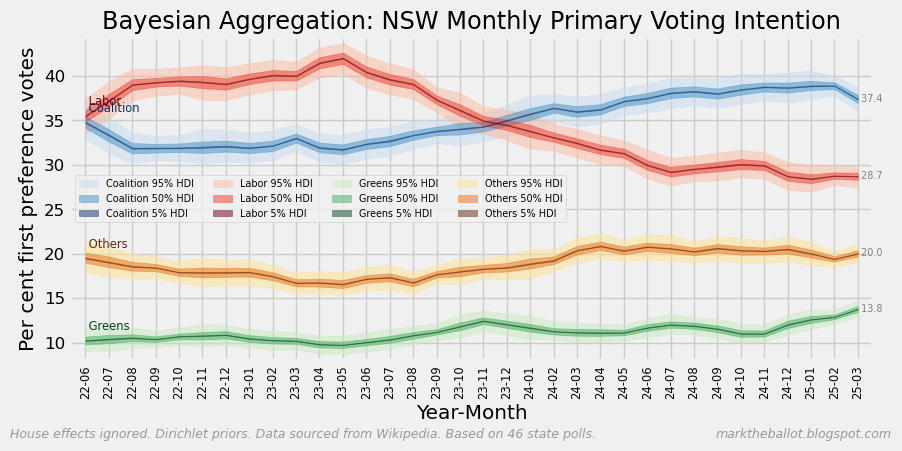

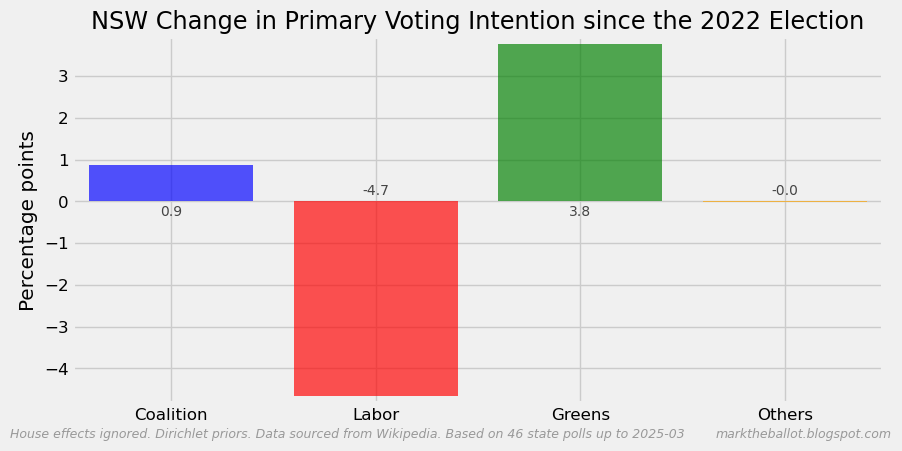

state='VIC' (340000, 4)


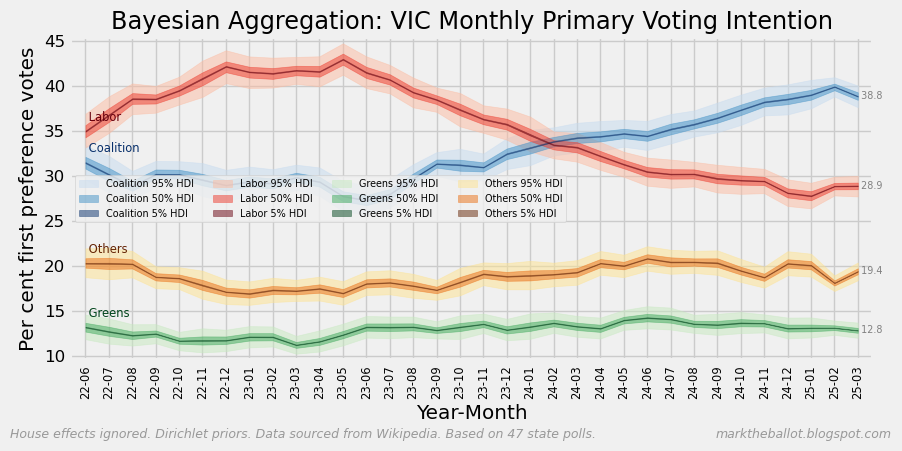

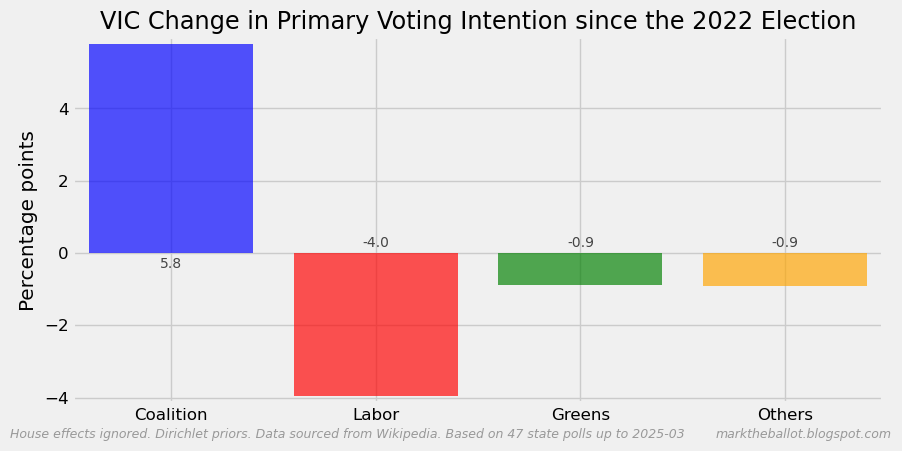

state='QLD' (340000, 4)


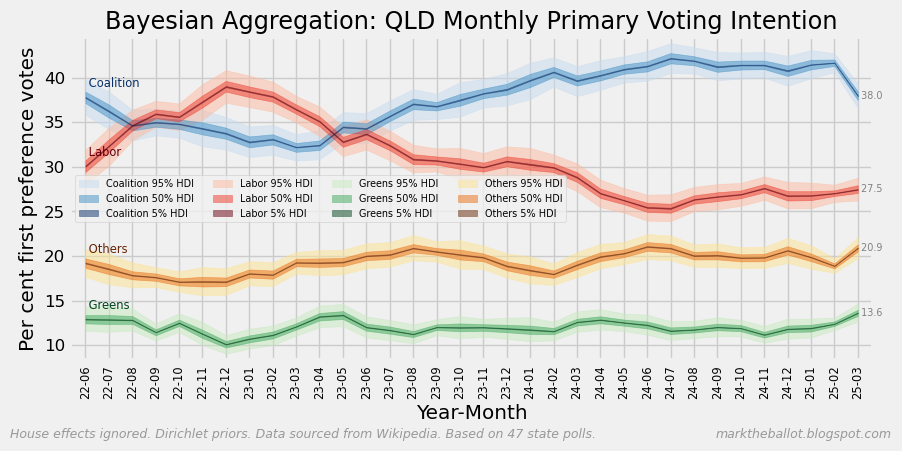

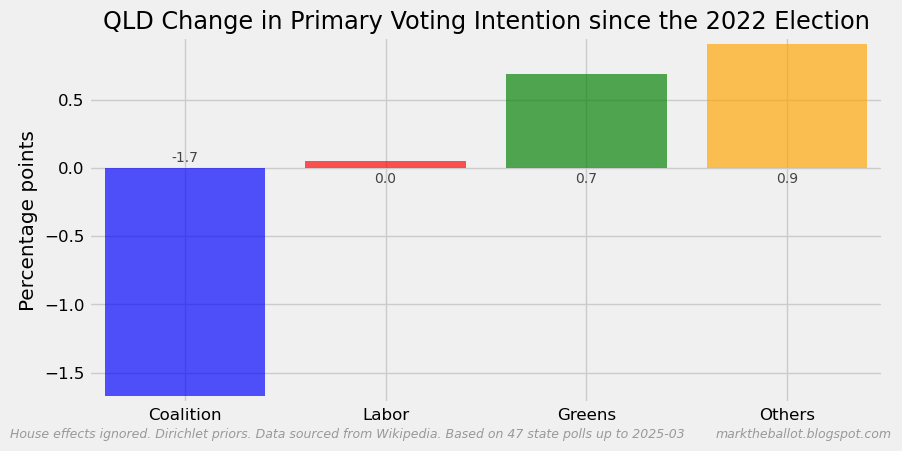

state='WA' (340000, 4)


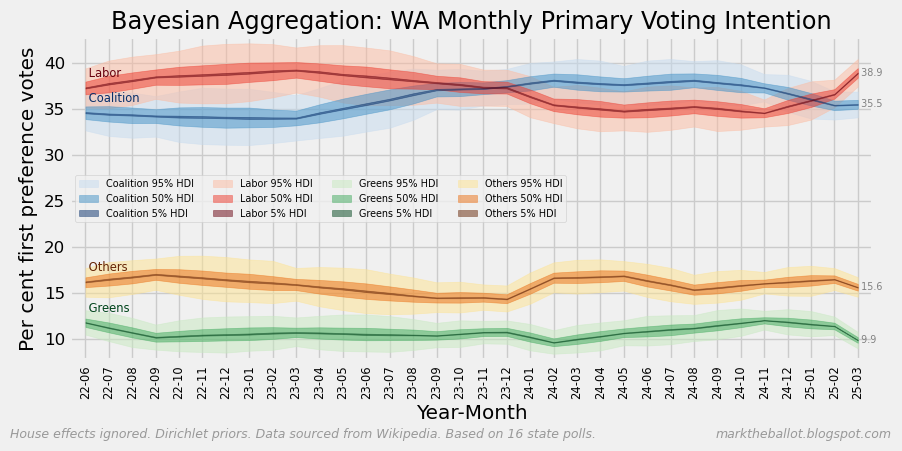

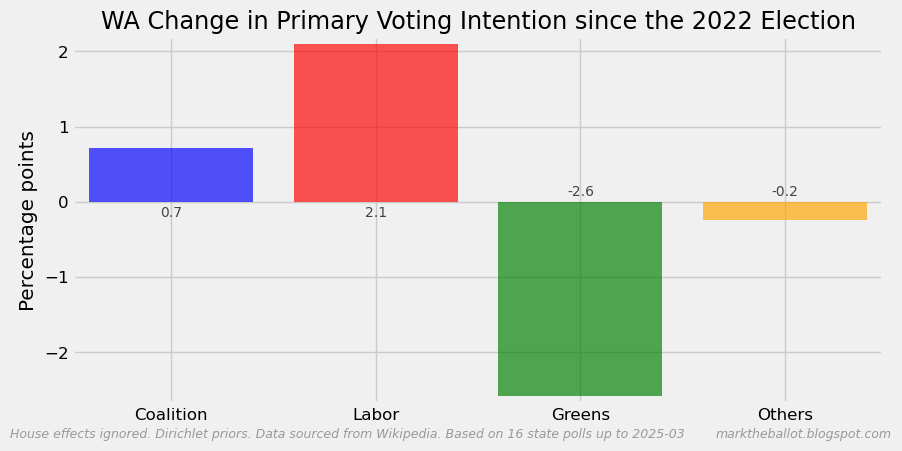

state='SA' (340000, 4)


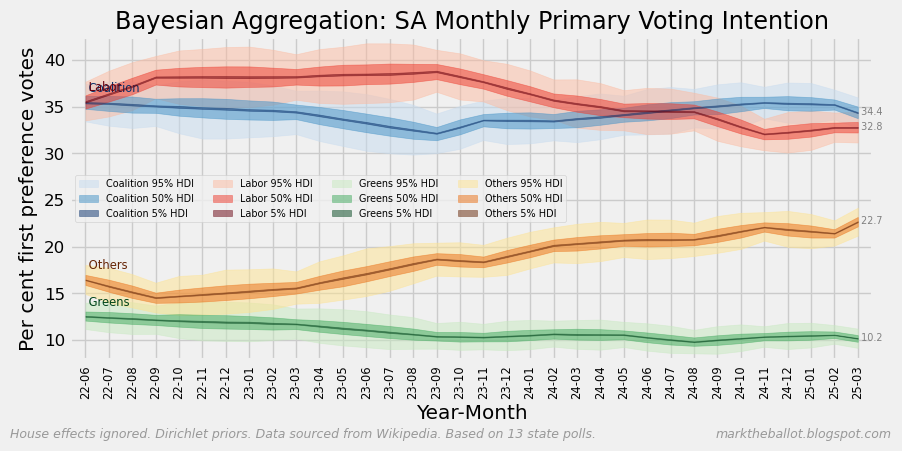

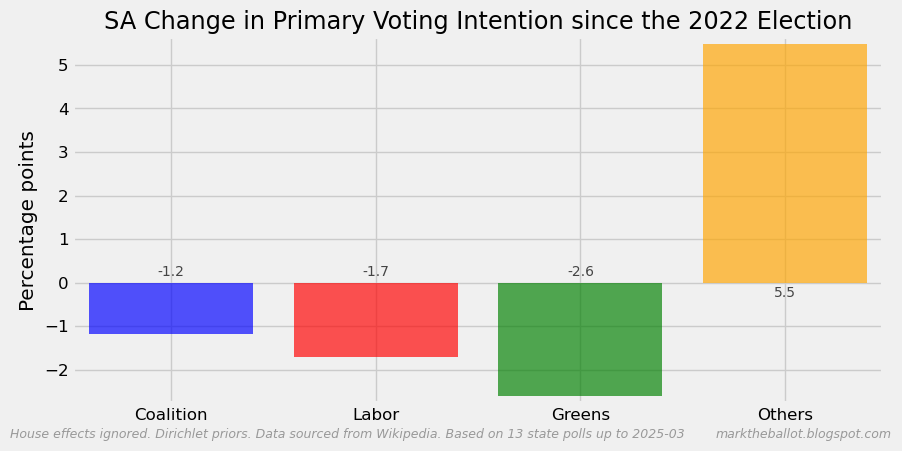

state='TAS' (340000, 4)


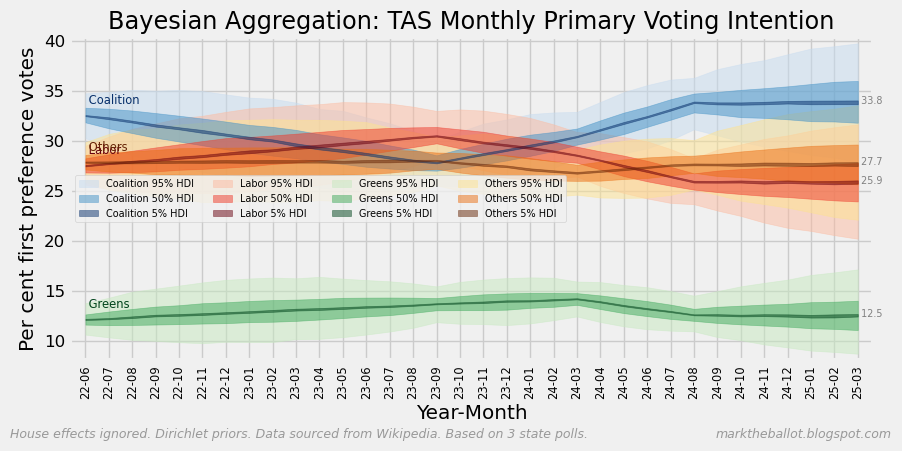

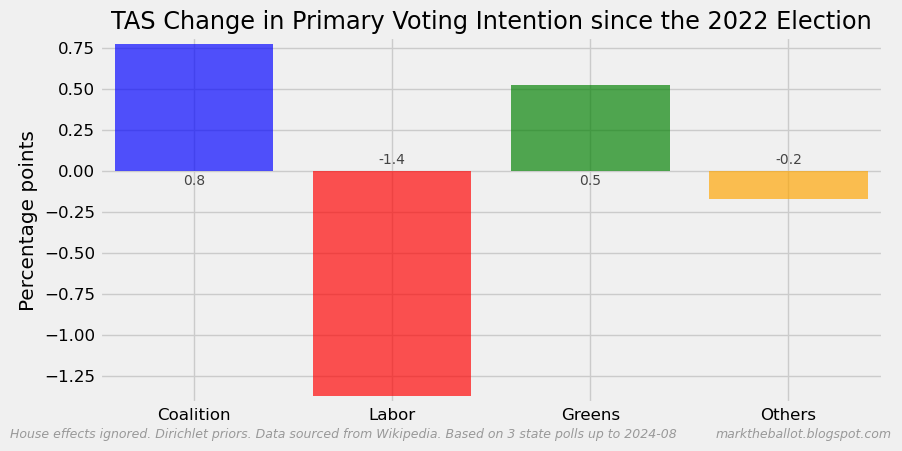

state='NT' (340000, 4)


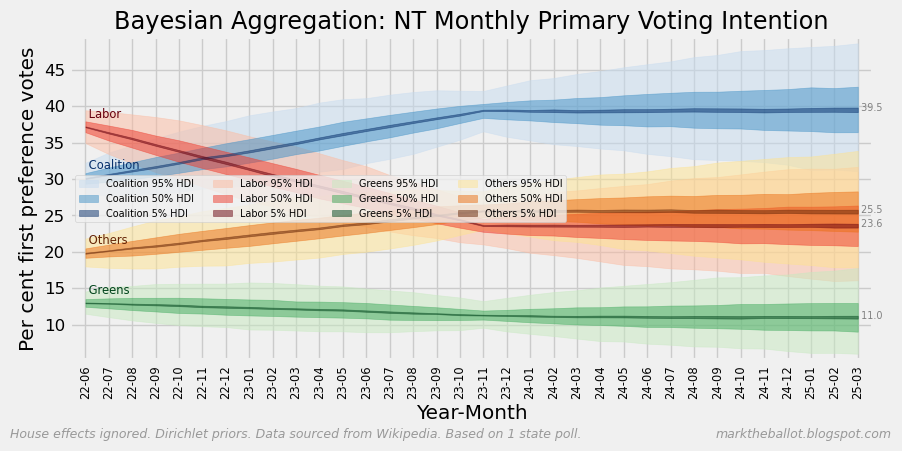

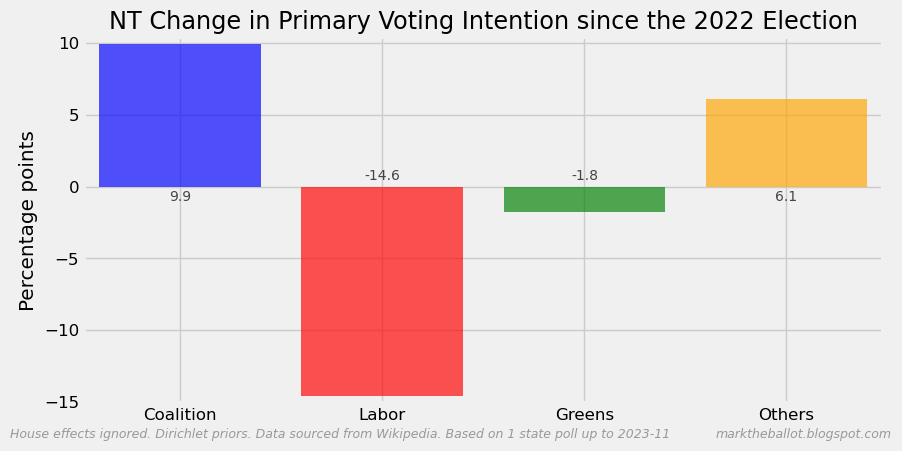

In [19]:
def state_plots() -> None:
    """Plot the state level results."""

    for state in ORDERED_STATES:
        if state not in model_results:
            continue
        _, glitches = model_results[state]
        vi_data: pd.DataFrame = pd.DataFrame(
            _get_var(state, "vi_stack").unstack(level="parties")
        )
        print(f"{state=} {vi_data.shape}")

        end_points = plot_state_timeseries(state, vi_data, glitches)
        plot_changes(state, glitches, end_points)


state_plots()

## Finished

In [20]:
print("Finished")

Finished
